# CNN for Trading

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. See the notebook cifar10_image_classification for implementation details; we will skip here over some repetitive steps. 

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import sys, os

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
size = 15
lookahead = 1

In [7]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

In [8]:
with pd.HDFStore('data.h5') as store:
    features = store['img_data']
    targets = store['targets']

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(225)
memory usage: 2.0+ GB


In [10]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 81.9+ MB


In [11]:
outcome = f'r{lookahead:02}_fwd'
features = features.join(targets[[outcome]]).dropna()
target = features[outcome]
features = features.drop(outcome, axis=1)

## Convolutional Neural Network

### Model Architecture

In [12]:
def make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32):
    input_shape = (size, size, 1)
    cnn = Sequential([
        Conv2D(filters=filter1,
               kernel_size=3,
               padding='same',
               activation=act1,
               input_shape=input_shape,
               name='CONV1'),
        Conv2D(filters=filter2,        
               kernel_size=3,  
               padding='same',
               activation=act2,
               name='CONV2'),
        MaxPooling2D(pool_size=2, name='POOL2'),
        Dropout(do1, name='DROP1'),
        Flatten(name='FLAT1'),
        Dense(dense, activation='relu', name='FC1'),
        Dropout(do2, name='DROP2'),
        Dense(1, activation='linear', name='FC2')
    ])
    cnn.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, 
                                                  momentum=0.9, 
                                                  nesterov=False, 
                                                  name='SGD'),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return cnn

In [13]:
cnn = make_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 15, 15, 16)        160       
_________________________________________________________________
CONV2 (Conv2D)               (None, 15, 15, 32)        4640      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 7, 7, 32)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 7, 7, 32)          0         
_________________________________________________________________
FLAT1 (Flatten)              (None, 1568)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 32)                50208     
_________________________________________________________________
DROP2 (Dropout)              (None, 32)                0

### Train the Model

In [14]:
train_period_length = 5 * 12 * 21
test_period_length = 5 * 21
n_splits = 16

In [15]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [16]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    return (x_train.reshape(-1, size, size, 1), y_train,
            x_val.reshape(-1, size, size, 1), y_val)

In [17]:
batch_size = 64

In [18]:
checkpoint_path = results_path / f'lookahead_{lookahead:02d}'
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

In [19]:
start = time()
ic  = []
for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
    X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
    preds = y_val.to_frame('actual')
    r = pd.DataFrame(index=y_val.index.unique(level='date')).sort_index()
    model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
    best_mean = best_median = -np.inf
    for epoch in range(25):         
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  epochs=epoch + 1,
                  initial_epoch=epoch,
                  verbose=0, shuffle=True)
        model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        preds[epoch] = model.predict(X_val).squeeze()
        r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
        print(f'{format_time(time()-start)} {fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
    ic.append(r.assign(fold=fold))
ic = pd.concat(ic)
ic.to_csv(checkpoint_path / 'ic.csv')

00:00:31 01 | 01 |  0.0086 |  0.0232
00:00:56 01 | 02 | -0.0117 | -0.0006
00:01:25 01 | 03 |  0.0133 |  0.0006
00:01:53 01 | 04 | -0.0072 | -0.0043
00:02:22 01 | 05 |  0.0136 |  0.0082
00:02:50 01 | 06 | -0.0026 | -0.0197
00:03:17 01 | 07 |  0.0020 |  0.0095
00:03:45 01 | 08 | -0.0108 | -0.0095
00:04:13 01 | 09 | -0.0103 | -0.0076
00:04:42 01 | 10 | -0.0125 | -0.0047
00:05:10 01 | 11 |  0.0136 | -0.0003
00:05:38 01 | 12 |  0.0137 |  0.0014
00:06:06 01 | 13 | -0.0053 | -0.0195
00:06:34 01 | 14 |  0.0095 |  0.0111
00:07:03 01 | 15 | -0.0111 | -0.0102
00:07:32 01 | 16 | -0.0058 | -0.0297
00:08:00 01 | 17 | -0.0132 | -0.0062
00:08:29 01 | 18 |  0.0038 |  0.0234
00:08:57 01 | 19 | -0.0055 | -0.0238
00:09:26 01 | 20 |  0.0129 |  0.0066
00:09:54 01 | 21 |  0.0050 |  0.0226
00:10:23 01 | 22 | -0.0023 | -0.0127
00:10:52 01 | 23 | -0.0133 | -0.0099
00:11:21 01 | 24 | -0.0121 | -0.0095
00:11:50 01 | 25 | -0.0106 | -0.0152
00:12:21 02 | 01 | -0.0057 | -0.0116
00:12:47 02 | 02 | -0.0059 | -0.0083
0

01:26:42 09 | 23 |  0.0218 |  0.0164
01:26:57 09 | 24 |  0.0213 |  0.0051
01:27:13 09 | 25 |  0.0223 |  0.0076
01:27:29 10 | 01 |  0.0089 |  0.0016
01:27:45 10 | 02 | -0.0070 | -0.0001
01:27:60 10 | 03 | -0.0059 |  0.0016
01:28:16 10 | 04 | -0.0051 |  0.0005
01:28:31 10 | 05 | -0.0044 |  0.0033
01:28:46 10 | 06 | -0.0032 | -0.0014
01:29:02 10 | 07 | -0.0024 |  0.0004
01:29:17 10 | 08 | -0.0008 | -0.0013
01:29:32 10 | 09 | -0.0016 | -0.0021
01:29:48 10 | 10 | -0.0019 | -0.0017
01:30:03 10 | 11 | -0.0006 | -0.0005
01:30:19 10 | 12 |  0.0014 |  0.0026
01:30:34 10 | 13 |  0.0048 |  0.0141
01:30:49 10 | 14 |  0.0050 |  0.0007
01:31:05 10 | 15 |  0.0055 |  0.0010
01:31:20 10 | 16 |  0.0047 |  0.0129
01:31:36 10 | 17 |  0.0057 | -0.0032
01:31:51 10 | 18 |  0.0047 | -0.0050
01:32:06 10 | 19 |  0.0038 |  0.0029
01:32:22 10 | 20 |  0.0017 | -0.0004
01:32:37 10 | 21 |  0.0045 |  0.0060
01:32:53 10 | 22 |  0.0041 |  0.0026
01:33:08 10 | 23 |  0.0054 |  0.0071
01:33:24 10 | 24 |  0.0049 |  0.0072
0

### Evaluate results

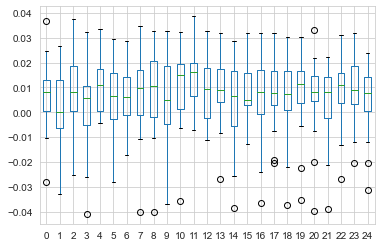

In [20]:
ic.groupby('fold').mean().boxplot();

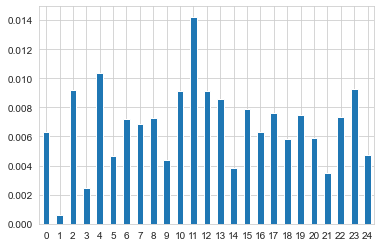

In [21]:
ic.groupby('fold').mean().mean().sort_index().plot.bar(rot=0);

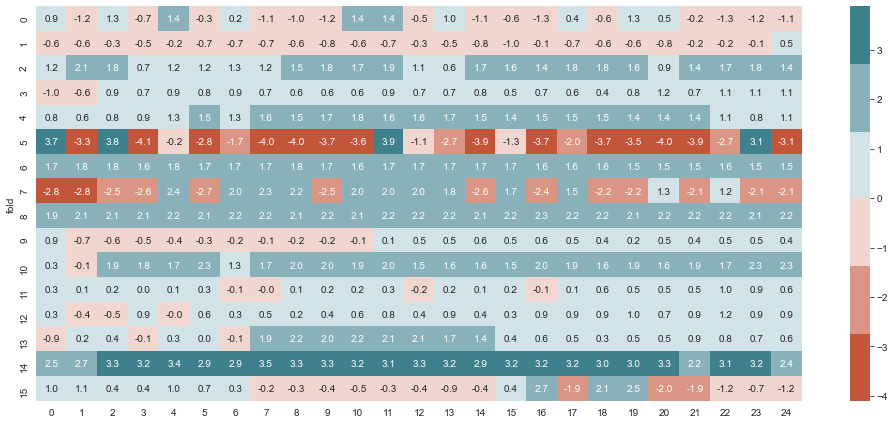

In [22]:
cmap = sns.diverging_palette(h_neg=20, h_pos=210)
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(ic.groupby('fold').mean().mul(100), ax=ax, center=0, cmap=cmap, annot=True, fmt='.1f')
fig.tight_layout()

## Make Predictions

In [23]:
def generate_predictions(epoch):
    predictions = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
        X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
        preds = y_val.to_frame('actual')
        model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
        status = model.load_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(X_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [24]:
preds = {}
for i, epoch in enumerate(ic.drop('fold', axis=1).mean().nlargest(5).index):
    preds[i] = generate_predictions(epoch)

In [25]:
with pd.HDFStore(results_path / 'predictions.h5') as store:
    store.put('predictions', pd.DataFrame(preds).sort_index())